<h1>The Philosopher Notebook</h1>
<h2>Quotes: downloading and fetching, quotes network, categories network, sentiment analysis</h2>

In [291]:
import os
import re
import requests
import json
import pandas as pd
import urllib
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import json
import numpy as np
import gensim
from collections import defaultdict
from matplotlib import colors
from wordcloud import WordCloud
import glob

nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package words to /home/mapac/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mapac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mapac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Download quotes

We use [WikiQuote](https://en.wikiquote.org/)'s API to retrieve the quotes of philosophers.

The standard WikiQuote page contains a lot of information other than the quotes itself, and unfortunately format varies a lot from page to page. We have chosen the following strategy to obtain the quotes:

1. Retrieve only the `Quotes` sections.

   A WikiQuote page contains usually a secion `Quotes` which contains the quotes we are interested in. Some pages spread quotes across multiple sections e.g. according to years (`Quotes 1950s-1980s` etc). Unfortunaly, the pages also include sections like `Displuted quotes` or `Quotes about X` which we are not interested in - therefore simply searching for  asection with word `quotes` wouldn't work. 

   After analysis of multiple pages and a magnitute of attempts we decided to first look for the section with name exactly `Quotes`. If such a section does not exist, we look for the first section including the name quotes, and then iterate through sections until finding a title matching one of the patterns: `Disputed`, `Misaatributions`, `External links`, `Quotes (on)|(about) *` etc:

   ```
   (?:==\s?Quotes (?:(?:about)|(?:on)) .*?\s?==)|(?:==\s?Misattributions\s?==)|(?:==\s?External links\s?==)|(?:==\s?See also\s?==)|(?:==\s?Quotations regarding .*?\s?==)
   ```

2. Basic clean-up

   The data comes with all sorts of wiki markdown, links, images, html tags, etc. We clean it up using regular expressions.

3. Retrieve quotes only

   The biggest challenge in retrieving the quotes comes from the `Quotes` sections containing a lot of other information than just quotes, and in very different ways. For example, in many places we can find the quotes in such a format:

   ```
   - *Quote...*
      - Information about quote, source, etc
      - Sometimes more than one bullet point with more details
   ```

   However, it is also very common to find them in format:
   ```
   - *Quote in the original language*
     - *Translation to English*
     - Information about quote, source, etc
     - Optionally other things
   ```
   
   To deal with that we have followed the following strategy:
   - We group the lines by the first level of bullet points (so one group is one bullet point from the highrst level and all its sub-points),
   - We tokenize and lemmatize the first line of the group,
   - We compare the tokens with the `words` copus which contains only ENglish words,
   - If more than 40% of the tokens from the line is not in the corpus, we decide the line is not English, and therefore we take the next line as a quote.

   This approach for sure does not work 100% of the time, but it prooved to be sufficient in vast majority of the cases.
   




In [184]:
df_philosophers = pd.read_csv('philosophers.csv') 
df_philosophers.head()

Name Birth/death dates                     File name
0           Aaron Ben-Ze'ev         born 1949           Aaron_Ben-Ze'ev.txt
1  Abd al-Latif al-Baghdadi         1162-1231  Abd_al-Latif_al-Baghdadi.txt
2        Abdolkarim Soroush         born 1945        Abdolkarim_Soroush.txt
3           Abdullah Laroui         born 1935           Abdullah_Laroui.txt
4        Abdullah al-Qasemi         1907–1996        Abdullah_al-Qasemi.txt

In [185]:
def create_query(page_title, revisions=False):
    """Creates a URL to make a query to retrieve content of 
    wikiquote page of the given title

    Parameters
    ----------
    page_title : str
       Title of the page whose content we want to query

    Returns
    ---------
    str
       URL to wikiquote API which can be used for querying content of page with
       given title
    """
    base_url_api = "https://en.wikiquote.org/w/api.php"
    action = "action=query"
    props = "prop=extracts&exlimit=1&explaintext"
    if revisions:
       props = "prop=revisions&rvprop=content&rvslots=*"
    dataformat = "format=json"
    titles = "titles=%s" % urllib.parse.quote_plus(page_title.replace(" ", "_"))
    query = "%s?%s&%s&%s&%s" % (base_url_api, action, titles, props, dataformat)
    return query

In [186]:
def query_wiki_page(page_title):
    """Makes a query to a wiki page and retrieves its content

    Parameters
    ----------
    page_title : str
       Title of the page whose content we want to query

    Raises
    ---------
    Exception
       If zero or more than 1 page was returned from query

    Returns
    ---------
    (str, bool)
       A tuple containing:
       - Content of the page in wikitext format
       - Boolean value which is true if page exists and false if it is missing

    """
    query = create_query(page_title, True)

    response = requests.get(query)
    wikidata = response.text
    wikitext = json.loads(wikidata)

    # Make sure `query.pages` contains only one entry. Raise exception otherwise
    pages = wikitext["query"]["pages"]

    if (len(pages) != 1):
        raise Exception("Expected one page, but query returned %d. Double check the page_title." % len(pages))

    # Now that we know that only one page was queried, we can retrieve its number
    page_num = list(pages.keys())[0]

    # If page_num == -1, it means that page does not exists
    if (page_num == "-1"):
      return None, False

    content = pages[page_num]["revisions"][0]["slots"]["main"]["*"]

    pattern = r"#(?:(?:REDIRECT)|(?:R|redirect)) \[\[(.*?)\]\]"
    page_to_redirect = re.match(pattern, content)
    if page_to_redirect:
        query = create_query(page_to_redirect.groups()[0] if page_to_redirect.groups()[0] is not None else page_to_redirect.groups()[1], True)
        response = requests.get(query)
        wikidata = response.text
        wikitext = json.loads(wikidata)
        pages = wikitext["query"]["pages"]
        if (len(pages) != 1):
            raise Exception("Expected one page, but query returned %d. Double check the page_title." % len(pages))
        page_num = list(pages.keys())[0]
        # If page_num == -1, it means that page does not exists
        if (page_num == "-1"):
            return None, False
        content = pages[page_num]["revisions"][0]["slots"]["main"]["*"]
        #content = pages[page_num]["extract"]

    return content, True

In [187]:
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

def process_quote(text, philosopher_name):
    """Processes content of the WikiQuote page of the philosopher:
       - Extracts only the `Quotes` section,
       - Discards links, wiki markdown leftovers,
       - Extracts only the quotes in English (or English translations of quotes in the original language),
         ignores the comments, sources, etc

    Parameters
    ----------
    text : str
       Content of the philosophees page
    philosopher_name : str
        Name od the philosopher

    Returns
    ---------
    list[string]
       List of cleaned quotes
    """
    # Keep what is after: == Quotes ==, and then also do some operation to be more easily cut in sentences, like get the *
    if text == None:
        return ''

    pattern_top = r"[^=]==[^=].*?[^=]==[^=]"
    position_top = re.search(pattern_top, text)
    if not position_top:
        print("No position_top: %s", philosopher_name, text)
        return ''
    text = text[position_top.end():]
    
    pattern_bottom = r"(?:==\s?Quotes (?:(?:about)|(?:on)) .*?\s?==)|(?:==\s?Misattributions\s?==)|(?:==\s?External links\s?==)|(?:==\s?See also\s?==)|(?:==\s?Quotations regarding .*?\s?==)"
    position_bottom = re.search(pattern_bottom, text)
    if  position_bottom:
        text = text[:position_bottom.start()]

    # Split by new line
    lines = text.split('\n')

    def discard_trivial_cases(line):
        if len(line) == 0:
            return False

        file_pattern = r"\[\[File:.*?\]\]$"
        match = re.search(file_pattern, line)
        if match:
            return False

        nested_header_pattern = r"===.*?==="
        match = re.search(nested_header_pattern, line)
        if match: 
            return False

        return True

    def remove_links_and_formatting(line):
        complex_link_pattern = r"\[\[.*?\|(.*?)\]\]"
        matches = re.findall(complex_link_pattern, line)
        for match in matches:
            line = re.sub(r"\[\[.*?\|.*?\]\]", match, line, 1)

        simple_link_pattern = r"\[\[(.*?)\]\]"
        matches = re.findall(simple_link_pattern, line)
        for match in matches:
            line = re.sub(r"\[\[.*?\]\]", match, line, 1)

        # Remove formatting
        line = re.sub("'", '', line)

        # Remove html tags
        line = re.sub(r"<.*?>", "", line)

        # Remove things like $ndash;
        line = re.sub(r"&\w*?;", '', line)

        return line
        

    lines =  [line for line in lines if discard_trivial_cases(line)]
    lines = [remove_links_and_formatting(line) for line in lines]

    def is_line_in_english(line):
        # text_vocab = set(w.lower() for w in line.lower().split(' '))
        tokens = nltk.tokenize.WordPunctTokenizer().tokenize(line.lower())

        stop = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))
        tokens = [i for i in tokens if i not in stop]
        lemmatizer = nltk.WordNetLemmatizer()
        tokens = set([lemmatizer.lemmatize(i) for i in tokens])
        
        unusual = tokens.difference(english_vocab)
        if len(unusual) > 0.4 * len(tokens):
            return False
        return True

    filtered_lines = []
    ignore_nested_bullets = True
    for line in lines:
        one_bullet_pattern = r"^\*(?:\w|\s)"
        match = re.search(one_bullet_pattern, line)
        if match: 
            if is_line_in_english(line):
                ignore_nested_bullets = True
                filtered_lines.append(line)
            else:
                ignore_nested_bullets = False
            continue
        if not ignore_nested_bullets:
            two_bullets_pattern = r"^\*\*(?:\w|\s)"
            match = re.search(two_bullets_pattern, line)
            if match:
                filtered_lines.append(line)
                ignore_nested_bullets = True

    return filtered_lines

Finally, use the methods above to download the quotes.

In [188]:
quotes_folder = 'philosophers_quotes'
if not os.path.exists(quotes_folder):
    os.makedirs(quotes_folder)

for i, row in df_philosophers.iterrows():
    # for all philosophers wikis
    name = row['Name']
    file_name = row['File name']
    quotes = process_quote(query_wiki_page(name)[0], name)
    if quotes != None and len(quotes) > 0:
        with open("%s/%s" % (quotes_folder, file_name), "w") as f:
            json.dump(quotes, f, indent=2)

# Building the Quotes network

In this section we are building the directed network based on quotes of philosophers refering to other philosophers:
 - The nodes correspond to the philosophers who have their their page in the service WikiQuote and who at least once mention other philosopher from the network in their quotes.
 - The links correspond to the quotes mentioning other philosophers: the source node correponds to the author of the quote and the target node to the mentioned philosopher.



## Process the quotes

This time we are interested in the **links** so we adjusted the `process_quote` method accordingly.

In [189]:
def process_quote(text, philosopher_name):
    """Processes content of the WikiQuote page of the philosopher:
       - Extracts only the `Quotes` section,
       - Discards wiki markdown leftovers, html tags
       - Detects the links to other philosophers
       - Extracts only the quotes in English (or English translations of quotes in the original language),
         ignores the comments, sources, etc
    

    Parameters
    ----------
    text : str
       Content of the philosophees page
    philosopher_name : str
        Name od the philosopher

    Returns
    ---------
    (list[string], list[string])
       A tuple of lists of the same length:
       - a list of quotes
       - a list of philosophers that are being mentioned in the corresponding quote
    """
    # keep what is after: == Quotes ==, and then also do some operation to be more easily cut in sentences, like get the *
    if text == None:
        return '', []

    pattern_top = r"[^=]==[^=].*?[^=]==[^=]"
    position_top = re.search(pattern_top, text)
    if not position_top:
        print("No position_top: %s", philosopher_name, text)
        return '', []
    text = text[position_top.end():]
    
    pattern_bottom = r"(?:==\s?Quotes (?:(?:about)|(?:on)) .*?\s?==)|(?:==\s?Misattributions\s?==)|(?:==\s?External links\s?==)|(?:==\s?See also\s?==)|(?:==\s?Quotations regarding .*?\s?==)"
    position_bottom = re.search(pattern_bottom, text)
    if  position_bottom:
        text = text[:position_bottom.start()]

    # Split by new line
    lines = text.split('\n')

    philosopher_names = set([row['Name'] for _, row in df_philosophers.iterrows()])

    def discard_trivial_cases(line):
        if len(line) == 0:
            return False

        file_pattern = r"\[\[File:.*?\]\]$"
        match = re.search(file_pattern, line)
        if match:
            return False

        nested_header_pattern = r"===.*?==="
        match = re.search(nested_header_pattern, line)
        if match: 
            return False

        return True

    def find_linked_philosophers(line):
        linked_philosophers = set()
        link_pattern = r"\[\[(.*?)\]\]"
        matches = re.findall(link_pattern, line)
        for match in matches:
            if match.find(':') != -1:
                continue
            page_name = match
            if match.find('|'):
                page_name = match.split('|')[0]
            if page_name in philosopher_names:
                linked_philosophers.add(page_name)
        return linked_philosophers

    def remove_links_and_formatting(line):
        complex_link_pattern = r"\[\[.*?\|(.*?)\]\]"
        matches = re.findall(complex_link_pattern, line)
        for match in matches:
            line = re.sub(r"\[\[.*?\|.*?\]\]", match, line, 1)

        simple_link_pattern = r"\[\[(.*?)\]\]"
        matches = re.findall(simple_link_pattern, line)
        for match in matches:
            line = re.sub(r"\[\[.*?\]\]", match, line, 1)

        # Remove formatting
        line = re.sub("'", '', line)

        # Remove html tags
        line = re.sub(r"<.*?>", "", line)

        # Remove things like $ndash;
        line = re.sub(r"&\w*?;", '', line)

        return line
        

    lines =  [line for line in lines if discard_trivial_cases(line)]
    linked_philosophers = [find_linked_philosophers(line) for line in lines]

    lines = [remove_links_and_formatting(line) for line in lines]

    def is_line_in_english(line):
        # text_vocab = set(w.lower() for w in line.lower().split(' '))
        tokens = nltk.tokenize.WordPunctTokenizer().tokenize(line.lower())

        stop = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))
        tokens = [i for i in tokens if i not in stop]
        lemmatizer = nltk.WordNetLemmatizer()
        tokens = set([lemmatizer.lemmatize(i) for i in tokens])
        
        unusual = tokens.difference(english_vocab)
        if len(unusual) > 0.4 * len(tokens):
            return False
        return True

    filtered_lines = []
    final_linked_philosophers_dict = {}
    ignore_nested_bullets = True

    for line, philosophers in zip(lines, linked_philosophers):
        one_bullet_pattern = r"^\*(?:\w|\s)"
        match = re.search(one_bullet_pattern, line)
        if match: 
            if is_line_in_english(line):
                ignore_nested_bullets = True
                filtered_lines.append(line)
                for linked_philosopher in philosophers:
                    if linked_philosopher not in final_linked_philosophers_dict:
                        final_linked_philosophers_dict[linked_philosopher] = []
                    final_linked_philosophers_dict[linked_philosopher].append(line)
            else:
                ignore_nested_bullets = False
            continue
        if not ignore_nested_bullets:
            two_bullets_pattern = r"^\*\*(?:\w|\s)"
            match = re.search(two_bullets_pattern, line)
            if match:
                filtered_lines.append(line)
                for linked_philosopher in philosophers:
                    if linked_philosopher not in final_linked_philosophers_dict:
                        final_linked_philosophers_dict[linked_philosopher] = []
                    final_linked_philosophers_dict[linked_philosopher].append(line)
                ignore_nested_bullets = True

    return filtered_lines, final_linked_philosophers_dict

## Create a graph of all philosophers

In [190]:
import networkx as nx

def create_graph_with_philosophers(philosophers_df):
    """Create NetworkX' Graph with isolated nodes. 
    Each node represents a philosopher.

    Parameters
    ----------
    philosophers_df : pandas.DataFrame
        DataFrame containing column `Name` values of which will become identifiers of nodes

    Returns
    ----------
    NetworkX.DiGraph
        A DiGraph with isolated nodes representing philosophers from provided DataFrame
    """
    G = nx.DiGraph()
    G.add_nodes_from([row['Name'] for _, row in philosophers_df.iterrows()])
    return G

In [191]:
G = create_graph_with_philosophers(df_philosophers)
print("Created graph with %d nodes and %d edges" % (G.number_of_nodes(), G.number_of_edges()))

Created graph with 1732 nodes and 0 edges


## Sentiment analysis with VADER

In [192]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vaderAnalyzer = SentimentIntensityAnalyzer()

def calculate_sentiment_vader(sentences):
  """Calculate the average polarity of given sentences.

  Parameters
  ----------
  sentences : list<str>
    A list of sentences we want to calculate sentiment for

  Returns
  ---------
  float
    Sentiment coefficient
  """
  polarities = [vaderAnalyzer.polarity_scores(sentence)["compound"] for sentence in sentences]
  return sum(polarities) / len(polarities)

## Add edges to the graph if a philosopher refers to another one in his/her quotes

Af a philosopher referred to another in their quotes, we create a link between these two: the author of the quotes is a source node and the referenced philosopher is the target one.

For every link we run sentiment analysis on the corresponding quotes and save the average result as an attribute `sentiment_score`.

In [193]:
quotes_folder = 'quotes_about_others'
if not os.path.exists(quotes_folder):
    os.makedirs(quotes_folder)

philosophers_popularity_data = {}
for i, row in df_philosophers.iterrows():
    name = row['Name']
    page = query_wiki_page(name)[0]
    quotes, linked_philosophers = process_quote(page, name)
    if quotes != None and len(quotes) > 0:
        sentiment_score = calculate_sentiment_vader(quotes)
        nx.set_node_attributes(G, {name: sentiment_score}, "sentiment_score")
        for philosopher in linked_philosophers.keys():
            # Create edge
            sentiment_score = calculate_sentiment_vader(linked_philosophers[philosopher])
            G.add_edge(name, philosopher, 
            sentiment_score=sentiment_score, 
            references_count=len(linked_philosophers[philosopher]))
            # Save quotes
            with open("quotes_about_others/" + name + "_" + philosopher +".txt", "w") as f:
                json.dump(linked_philosophers[philosopher], f)
            
            # Add quotes to philosophers_popularity_data
            if philosopher not in philosophers_popularity_data:
                philosophers_popularity_data[philosopher] = {"scores_sum": 0, "scores_cnt": 0}
            philosophers_popularity_data[philosopher]["scores_sum"] += sentiment_score
            philosophers_popularity_data[philosopher]["scores_cnt"] += 1

print("Now graph G has %d nodes and %d edges" % (G.number_of_nodes(), G.number_of_edges()))

Now graph G has 1732 nodes and 739 edges


In [194]:
# Set popularity score for philosophers
nx.set_node_attributes(G, {name: {"popularity_score": value["scores_sum"]/value["scores_cnt"]} for name, value in philosophers_popularity_data.items()})

# Save graph to GEXF file

In [195]:
nx.write_gexf(G, "quotes_network.gexf")

## Load graph from GEXF file

In [196]:
G = nx.read_gexf("quotes_network.gexf")

## Basic statistics of the graph

In [197]:
print("There are %d isolated nodes in G" % len(list(nx.isolates(G))))

There are 1394 isolated nodes in G


In [198]:
G.remove_nodes_from(list(nx.isolates(G)))
print("Now graph G has %d nodes and %d edges" % (G.number_of_nodes(), G.number_of_edges()))

Now graph G has 338 nodes and 739 edges


In [199]:
def find_most_connected_nodes(G, n):
  """Given a node G, find n most connected nodes in terms of
  degree, in-degree and out-degree

  Parameters
  ----------
  G : nx.DiGraph
    DiGraph to be analyzed
  n : int
    Number of top connected nodes to be returned

  Returns
  ----------
  (list<(string, int)>, list<(string, int)>, list<(string, int)>) 
    A triplet with 3 lists, each list containing n tuples consisting of 
    a name of a character and a number of connections he/she has, corresponding
    to the n top connected characters.
    First list contains results in terms of undirected graph, second list in
    terms of in-degrees, and thirs list in terms of out-degrees.
  """
  return (
      sorted(G.degree, key=lambda x: x[1], reverse=True)[:n],
      sorted(G.in_degree, key=lambda x: x[1], reverse=True)[:n],
      sorted(G.out_degree, key=lambda x: x[1], reverse=True)[:n]
  )

In [200]:
# Top 10 connected allies 
top_connected_philosophers = find_most_connected_nodes(G, 10)

# Print results
print("10 top connected philosophers in undirected network:\n  - %s" 
      % "\n  - ".join(["%s: degree: %d" % tuple for tuple in top_connected_philosophers[0]]))

print("\n10 top connected philosophers in terms of in-degree:\n  - %s" 
      % "\n  - ".join(["%s: degree: %d" % tuple for tuple in top_connected_philosophers[1]]))

print("\n10 top connected philosophers in terms of out-degree:\n  - %s" 
      % "\n  - ".join(["%s: degree: %d" % tuple for tuple in top_connected_philosophers[2]]))

10 top connected philosophers in undirected network:
  - Aristotle: degree: 44
  - Plato: degree: 41
  - Karl Marx: degree: 29
  - Colin Wilson: degree: 27
  - Isaac Newton: degree: 23
  - Bertrand Russell: degree: 22
  - John Stuart Mill: degree: 22
  - Martin Luther King Jr.: degree: 22
  - Immanuel Kant: degree: 21
  - John Gray (philosopher): degree: 21

10 top connected philosophers in terms of in-degree:
  - Plato: degree: 41
  - Aristotle: degree: 35
  - Karl Marx: degree: 25
  - Isaac Newton: degree: 22
  - Socrates: degree: 18
  - Immanuel Kant: degree: 16
  - Georg Wilhelm Friedrich Hegel: degree: 14
  - Pythagoras: degree: 14
  - Adam Smith: degree: 13
  - Galileo Galilei: degree: 13

10 top connected philosophers in terms of out-degree:
  - Colin Wilson: degree: 27
  - Martin Luther King Jr.: degree: 22
  - John Gray (philosopher): degree: 21
  - George Steiner: degree: 19
  - Herbert Marcuse: degree: 14
  - John Stuart Mill: degree: 14
  - Augustus De Morgan: degree: 13
  

**Observation**

The most interesting results are the top connected philosophers in terms of in-degree: this can be basically interpreted as the most influential philosophers - the once referenced by others the most. Not suprisingly, the winner is Plato - although we expected more ancient greece philosophers to occupy the top spots, Karl Marx at the first place is not what we expected.

### Degree distirbution plots

In [201]:
sns.set_style('darkgrid')

def plot_degree_distribution(degrees, type_of_degree):
    """Plots degree distribution given list of degrees of every node in network
    
    Parameters
    ----------
    degrees : list<int>
        List of number of degrees per every node in the network
    type_of_degree : str
        Degree/In-degree/Out-degree: used in plot's title and axis names
    """
    hist_x, hist_y = np.unique(degrees, return_counts=True)

    plt.figure(figsize=(15,8))
    plt.suptitle("%s distribution" % type_of_degree)
    plt.subplot(2,2,1)

    ax1 = sns.histplot(data=degrees, binwidth=1)
    ax1.set(title="Histogram of the %s distribution" % type_of_degree.lower(), xlabel=type_of_degree, ylabel="Frequency")

    plt.subplot(2,2,2)
    ax2 = sns.scatterplot(x=hist_x, y=hist_y)
    ax2.set(xscale='log', yscale='log', xlabel=type_of_degree, ylabel="Frequency", title="%s distribution (Log-Log)" % type_of_degree)
    ax2.set_ylim(bottom=0.5, top=10e2)
    ax2.set_xlim(left=0.5, right=1000)
    plt.show()

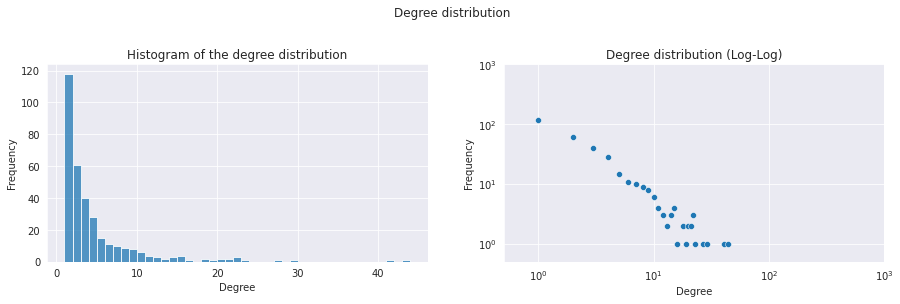

In [202]:
degrees = [G.degree(n) for n in G.nodes()]
plot_degree_distribution(degrees, "Degree")

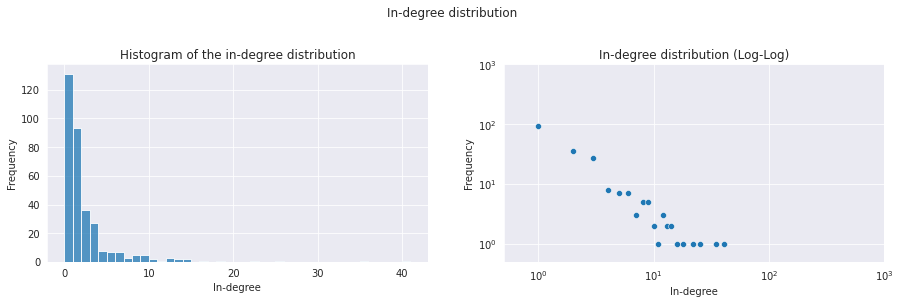

In [203]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
plot_degree_distribution(in_degrees, "In-degree")

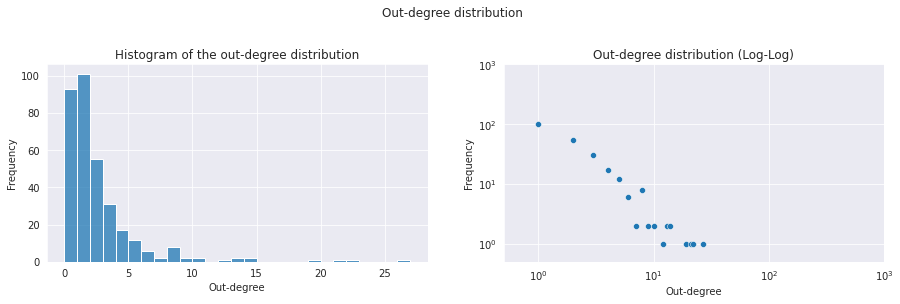

In [204]:
out_degrees = [G.out_degree(n) for n in G.nodes()]
plot_degree_distribution(out_degrees, "Out-degree")

### Most and least popular philosophers

Let's find top 10 philosophers with highest and lowest popularity scores

In [205]:
popularity_scores = nx.get_node_attributes(G, "popularity_score")
most_popular_philosophers = sorted([(name, popularity_scores[name]) for name in G.nodes() if name in popularity_scores], key=lambda x: x[1], reverse=True)

print("\n10 top most popular philosophers:\n  - %s" 
      % "\n  - ".join(["%s: popularity score: %f" % tuple for tuple in most_popular_philosophers[:10]]))


10 top most popular philosophers:
  - Alfred Adler: popularity score: 0.999000
  - Marquis de Condorcet: popularity score: 0.997800
  - Mencius: popularity score: 0.994300
  - Meister Eckhart: popularity score: 0.983600
  - James Mill: popularity score: 0.982700
  - Mikhail Bakunin: popularity score: 0.981500
  - Archytas: popularity score: 0.981100
  - Joseph Addison: popularity score: 0.972100
  - Tommaso Campanella: popularity score: 0.970600
  - Noam Chomsky: popularity score: 0.968500


### Most and least popular philosophers

Let's find top 10 philosophers with highest and lowest popularity scores

In [206]:
least_popular_philosophers = sorted([(name, popularity_scores[name]) for name in G.nodes() if name in popularity_scores], key=lambda x: x[1])

print("\n10 top least popular philosophers:\n  - %s" 
      % "\n  - ".join(["%s: popularity score: %f" % tuple for tuple in least_popular_philosophers][:10]))


10 top least popular philosophers:
  - Giacomo Leopardi: popularity score: -0.981300
  - Franz Kafka: popularity score: -0.953800
  - Friedrich Hölderlin: popularity score: -0.950100
  - Henry David Thoreau: popularity score: -0.916700
  - George Berkeley: popularity score: -0.863600
  - Friedrich Schelling: popularity score: -0.859100
  - Melissus of Samos: popularity score: -0.839900
  - Swami Vivekananda: popularity score: -0.817300
  - Giovanni Gentile: popularity score: -0.771700
  - T. S. Eliot: popularity score: -0.676150


### Most critical philosophers

Let's find top 10 philosophers whose quotes about others were most critical

In [207]:
sentiment_scores = nx.get_edge_attributes(G, "sentiment_score")
most_critical_philosophers = sorted([(name, np.average([sentiment_scores[edge] for edge in G.out_edges(name)])) for name in G.nodes() if len(G.out_edges(name)) > 0], key=lambda x: x[1])

print("\n10 top most critical philosophers:\n  - %s" 
      % "\n  - ".join(["%s: average sentiment score: %f" % tuple for tuple in most_critical_philosophers][:10]))


10 top most critical philosophers:
  - David Friedrich Strauss: average sentiment score: -0.886300
  - Linus Pauling: average sentiment score: -0.877900
  - Sun Yat-sen: average sentiment score: -0.860200
  - Jean Piaget: average sentiment score: -0.834600
  - Isaiah Berlin: average sentiment score: -0.830000
  - William Blake: average sentiment score: -0.826800
  - Mircea Eliade: average sentiment score: -0.787200
  - Paul Valéry: average sentiment score: -0.775900
  - Jiddu Krishnamurti: average sentiment score: -0.752325
  - Erich Fromm: average sentiment score: -0.706275


## Visualisation of the network

In [208]:
# Convert DiGraph to Graph
H = G.to_undirected()

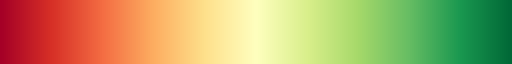

In [209]:
palette = sns.color_palette("RdYlGn", as_cmap=True)
palette

In [210]:
# Methods for choosing nodes and edges colors based on role property

from matplotlib import colors

def choose_color(sentiment_score):
  """Return hex color code based on sentiment score

  Parameters
  ----------
  role : str
    Role of a character

  Returns
  ----------
  str
    Hex code of color corresponding to the role
  """
  normalized_score = (sentiment_score + 1) / 2
  return colors.rgb2hex(palette(normalized_score))

100%|██████████| 2000/2000 [00:02<00:00, 882.72it/s]


BarnesHut Approximation  took  0.78  seconds
Repulsion forces  took  1.25  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


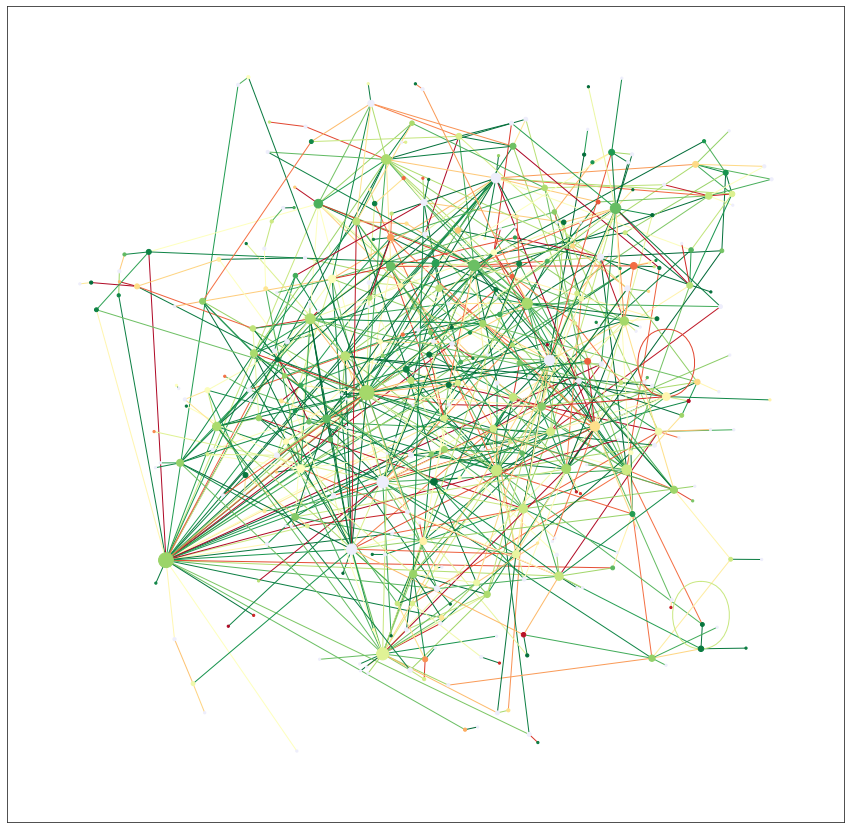

In [211]:
from fa2 import ForceAtlas2

sns.set_style('white')

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,

    # Performance
    jitterTolerance=0.01,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1,

    # Tuning
    scalingRatio=0.1,
    strongGravityMode=False,
    gravity=0.1,

    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(H, pos=None, iterations=2000)

plt.figure(figsize=(15,15))
nodes = H.nodes()
edges = H.edges()
nx.draw_networkx(H,
                  positions,
                  node_size=[H.degree(node) * 5 for node in H.nodes()],
                  node_color=[choose_color(y['popularity_score']) if 'popularity_score' in y else "#eeeefc" for _, y in G.nodes(data=True)],
                  edge_color=[choose_color(nx.get_edge_attributes(G, 'sentiment_score')[(u, v)]) for u,v in G.edges()],
                  with_labels=False)
plt.show()

## Save positions and colors to graph 
(needed for SigmaJS library to render the graph in the webpage)

In [212]:
position_attrbs = {node: {"x": value[0], "y": value[1]} for node, value in positions.items()}
nx.set_node_attributes(G, position_attrbs)

In [213]:
popularity_scores = nx.get_node_attributes(G, 'popularity_score')
nx.set_node_attributes(G, name='color', values={name: choose_color(popularity_scores[name]) if name in popularity_scores else "#eeeefc" for name in G.nodes()})
in_degrees = {name: G.in_degree(name) for name in G.nodes()}

nx.set_node_attributes(G, name='in_degree', values=in_degrees)
nx.set_node_attributes(G, name='size', values={d: int(in_degrees[d]) + 1 for d in in_degrees.keys()})
nx.set_edge_attributes(G, name='color', values={(u, v): choose_color(nx.get_edge_attributes(G, 'sentiment_score')[(u, v)]) for u,v in G.edges()})
nx.set_edge_attributes(G, name='hover_width', values={(u, v): nx.get_edge_attributes(G, 'references_count')[(u, v)] * 2 for u,v in G.edges()})
nx.set_edge_attributes(G, name='select_color', values={(u, v): choose_color(nx.get_edge_attributes(G, 'sentiment_score')[(u, v)]) for u,v in G.in_edges()})


In [214]:
nx.write_gexf(G, "enhanced_quotes_network.gexf")

# Top Words In Quotes

What do philosophers talk about, in general? Or if they posted in social media nowadays, what would be the most common tags? We have decided to extract the most frequent and meaningful 1000 words from the philosophers quotes to find out!

In [215]:
# We create a corpus with philosophers names - we filter out these tokens from the quotes
tokenizer = nltk.WordPunctTokenizer()
name_tokens = [tokenizer.tokenize(row['Name'].lower()) for _, row in df_philosophers.iterrows()]
name_tokens = [token for sublist in name_tokens for token in sublist]

In [216]:
def preprocess_text(content):
    """Given a string with text, convert it into tokens and clean them
    from punctuation, stopwords and philosopher names
    
    Parameters
    -----------
    content : str
        A text from which tokens will be extracted

    Returns
    -----------
    list<str>
        A list of lemmatized and cleaned tokens
    """
    # Make content lowercase
    content = content.lower()

    # Tokenize text
    tokens = nltk.WordPunctTokenizer().tokenize(content)

    # Remove punctuation and stopwords
    stop = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))
    tokens = [i for i in tokens if i not in stop]

    other = ["...", ",\"", ",", "—", "“", "’", "…", "**", ".\""]
    tokens = [i for i in tokens if i not in other]

    # Remove philosopher names
    tokens = [i for i in tokens if i not in name_tokens]

    # Lemmatize words
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(i) for i in tokens]

    return tokens

In [217]:
def remove_links_and_formatting(line):
    """Given a quote, clean it up from links, html tags, 
    and wiki markdown elements
    
    Parameters
    -----------
    line : str
        A line / quote

    Returns
    -----------
    str
        Cleaned line / quote
    """
    complex_link_pattern = r"\[\[.*?\|(.*?)\]\]"
    matches = re.findall(complex_link_pattern, line)
    for match in matches:
        line = re.sub(r"\[\[.*?\|.*?\]\]", match, line, 1)

    simple_link_pattern = r"\[\[(.*?)\]\]"
    matches = re.findall(simple_link_pattern, line)
    for match in matches:
        line = re.sub(r"\[\[.*?\]\]", match, line, 1)

    # Remove formatting
    line = re.sub("'", '', line)

    # Remove html tags
    line = re.sub(r"<.*?>", "", line)

    # Remove things like $ndash;
    line = re.sub(r"&\w*?;", '', line)

    # Remove all stars
    line = re.sub(r"\*", "", line)

    return line

### Load philosopher quotes into documents

We create a document per each philosopher, that is, tokens from all the quotes from one philosopher will all be in one document.

In [218]:
texts = []
philosophers = []

for _, row in df_philosophers.iterrows():
    filepath = '../../philosophers_quotes/' + row['File name']
    if os.path.exists(filepath):
        philosophers.append(row['Name'])
        with open(filepath) as f:
            quotes = json.load(f)
            all_tokens = []
            for quote in quotes:
                all_tokens.extend(preprocess_text(remove_links_and_formatting(quote)))
            texts.append(all_tokens)

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

In [219]:
# Save tokens to file
philosophers_tokens_dict = {philosopher: tokens for philosopher, tokens in zip(philosophers, texts)}
with open("tokens_per_philosopher.json", "w") as f:
    json.dump(philosophers_tokens_dict, f)

## Find most frequent words (TF)

In [220]:
most_frequent = sorted(frequency.keys(), key=lambda x: frequency[x], reverse=True)
print(most_frequent[:100])

['one', 'life', 'god', 'thing', 'world', 'u', 'would', 'must', 'may', 'men', 'time', 'people', 'human', 'without', 'make', 'every', 'even', 'nature', 'know', 'good', 'great', 'like', 'say', 'power', 'love', 'way', 'truth', 'mind', 'nothing', 'cannot', 'thought', 'never', 'state', 'first', 'mean', 'much', 'see', 'right', 'upon', 'work', 'think', 'reason', 'many', 'come', 'science', 'word', 'knowledge', 'true', 'also', 'new', 'could', 'always', 'form', 'fact', 'part', 'well', 'whole', 'society', 'made', 'others', 'two', 'idea', 'religion', 'another', 'give', 'order', 'shall', 'take', 'yet', 'find', 'soul', 'therefore', 'self', 'individual', 'end', 'become', 'principle', 'body', 'day', 'sense', 'something', 'long', 'go', 'matter', 'let', 'ever', 'said', 'thus', 'social', 'believe', 'history', 'system', 'place', 'still', 'spirit', 'kind', 'need', 'far', 'force', 'question']


The obtained most frequent words are not all very informative: e.g. words such as `one` or  `thing` bear no real meaning for us. That's why we will also try to run TF-IDF for each document (that is: list of quotes of one philosopher) and then filter the most frequent words based on the results. 

## Create and run TF-IDF model

This time we use Gensim library to calculate TF-IDF, therefore we need to create a dictionary from all the documents and a corpus for each document.

In [221]:
dictionary = gensim.corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [222]:
tfidf = gensim.models.TfidfModel(corpus, id2word=dictionary)
corpus_tfidf = tfidf[corpus]

In [223]:
scores = {}
for doc in corpus_tfidf:
    for id, value in doc:
        word = dictionary.get(id)
        if word not in scores:
            scores[word] = []
        scores[word].append(value)

**How to use TF-IDF data?**

TF-IDF gives us a coefficient which is meaningful in the context of a document vs other documents in some group. Reusing this value for getting most meaningful words for *all* the philosophers is a bit less straighforward.

We were playing with the results for a while to see which strategy would work best. Eventually, we decided to sort the words according to TF score, and then filter out the ones whose **maximal** TF-IDF score is lower than some threshold (we experimentally chosen 0.15). We also tried out using the average TF-IDF score for filtering, but the maximal gave us much better results. This strategy also intuitively makes sense - if a word was not significant for any philosopher, then it probably is not very significant at all. But if there was at least one philosopher for whom the word scored high, then there is a chance that this word bears some significance.

In [224]:
import numpy as np
most_frequent = sorted(frequency.keys(), key=lambda x: frequency[x], reverse=True)
filtered_frequent = [w for w in most_frequent if w in scores and np.max(scores[w]) > 0.15]
top_words = [word for word in filtered_frequent[:100]]
top_words

['life',
 'god',
 'world',
 'men',
 'people',
 'human',
 'even',
 'power',
 'love',
 'truth',
 'mind',
 'nothing',
 'thought',
 'state',
 'right',
 'reason',
 'science',
 'word',
 'knowledge',
 'true',
 'new',
 'society',
 'others',
 'two',
 'idea',
 'religion',
 'give',
 'order',
 'soul',
 'self',
 'individual',
 'principle',
 'body',
 'sense',
 'something',
 'long',
 'said',
 'social',
 'believe',
 'history',
 'system',
 'still',
 'spirit',
 'need',
 'force',
 'question',
 'war',
 'free',
 'death',
 'hand',
 'freedom',
 'experience',
 'want',
 'heart',
 'country',
 'cause',
 'real',
 'possible',
 'act',
 'earth',
 'art',
 'light',
 'government',
 'better',
 'child',
 'theory',
 'nation',
 'moral',
 'evil',
 'desire',
 'condition',
 'opinion',
 'faith',
 'book',
 'value',
 'political',
 'reality',
 'problem',
 'class',
 'feeling',
 'interest',
 'best',
 'virtue',
 'universe',
 'moment',
 'rule',
 'alone',
 'found',
 'belief',
 'woman',
 'number',
 'meaning',
 'justice',
 'divine',
 'c

## Prepare a graph

We wanted to represent the top 1000 words we just found with a AntV / G6 library by recycling the [Christmas Bubbles](https://g6.antv.vision/en/examples/case/graphDemos#christmasBubbles) example. In order to achieve it, we needed to prepare a JSON file with the following data:
 - a list of bubbles - in our case top words - with their color and size. We will set color according to the word's sentiment score, and size according to the TF score,
 - a list of connections - the cool things about the graph is that it's interactive! We wanted to use this functionality to allow seeing which philosophers were using a given word in their quotes - that's why we additionally had to add nodes with all these philosophers and links from linking philosophers and the word.

### Prepare color palette

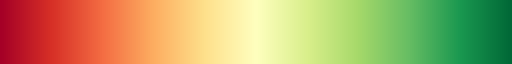

In [225]:
palette = sns.color_palette("RdYlGn", as_cmap=True)
palette

## Read LabMIT words for top words

We use labMIT dataset to read a sentiment score of a word - then we'll use it for coloring.

In [226]:
labMIT_wordlist = {}
with open("labMIT_dataset.txt", "r") as f:
  for line in f.readlines()[4:]:
    tabs = line.split("\t")
    labMIT_wordlist[tabs[0]] = float(tabs[2].strip())

In [227]:
for word in top_words:
    if word not in labMIT_wordlist:
        print("%s not in labMIT list" % word)

### Add nodes with top 1000 words to the JSON

In [228]:
from matplotlib import colors

data = {
    "nodes": [],
    "edges": []
}

for word in top_words:
    data["nodes"].append({
        "text": word,
        "id": word,
        "count": frequency[word],
        "color": colors.rgb2hex(palette(labMIT_wordlist[word]/10))
    })


### Add neighboring nodes with philosophers

In [229]:
relevant_philosophers_tuples = {}
for word in top_words:
    relevant_philosophers_tuples[word] = []

    for philosopher, doc in zip(philosophers, corpus_tfidf):
        for id, value in doc:
            if dictionary[id] == word:
                relevant_philosophers_tuples[word].append((philosopher, value))

In [230]:
for word in relevant_philosophers_tuples.keys():
    philosophers_tuples = relevant_philosophers_tuples[word]
    top_philosophers = sorted([t for t in philosophers_tuples if t[1] > 0.1], key=lambda x: x[1], reverse=True)
    
    for philosopher_value_tuple in top_philosophers:
        data["nodes"].append({
            "text": philosopher_value_tuple[0],
            "id": philosopher_value_tuple[0] + "_" + word,
            "count": int(frequency[word] * philosopher_value_tuple[1] / top_philosophers[0][1]),
            "centerNode": word,
            "neighbor": True
        })
        data["edges"].append({
            "source": word,
            "target": philosopher_value_tuple[0] + "_" + word
        })

# Save the file
with open("top_words.json", "w") as f:
    json.dump(data, f)

Unfortunately, we haven't found a way to include JavaScript script in Jupiter notebook so we can't show you the result here, but make sure to visit out webpage and go to the `Quotes` tab to check it out - the result is really cool!

# Philosophers network based on common categories and tags

Create a network with nodes of different types: philosophers, categories and tags, where philosophers are connected with categories and tags.

## Create a new Graph and add philosophers to it

In [231]:
def create_graph_with_philosophers(philosophers_df):
    """Create NetworkX' Graph with isolated nodes. 
    Each node represents a philosopher.

    Parameters
    ----------
    philosophers_df : pandas.DataFrame
        DataFrame containing column `Name` values of which will become identifiers of nodes

    Returns
    ----------
    NetworkX.DiGraph
        A DiGraph with isolated nodes representing philosophers from provided DataFrame
    """
    G = nx.Graph()
    G.add_nodes_from([(row['Name'], {"category": "philosopher"}) for _, row in philosophers_df.iterrows()])
    return G

In [232]:
G = create_graph_with_philosophers(df_philosophers)
print("Created graph with %d nodes and %d edges" % (G.number_of_nodes(), G.number_of_edges()))

Created graph with 1732 nodes and 0 edges


## Add color based on quotes sentiment analysis to philosophers

In [233]:
def choose_color(sentiment_score):
  """Return hex color code based on sentiment score

  Parameters
  ----------
  role : str
    Role of a character

  Returns
  ----------
  str
    Hex code of color corresponding to the role
  """
  normalized_score = (sentiment_score + 1) / 2
  return colors.rgb2hex(palette(normalized_score))

for _, row in df_philosophers.iterrows():
    filepath = '../../philosophers_quotes/' + row['File name']
    if os.path.exists(filepath):
        with open(filepath) as f:
            quotes = json.load(f)
            score = calculate_sentiment_vader(quotes)
            nx.set_node_attributes(G, {row["Name"]: score}, "sentiment_score")
            nx.set_node_attributes(G, {row["Name"]: choose_color(score)}, "color")
    else:
        nx.set_node_attributes(G, {row["Name"]: "#eeeefc"}, "color")

### Find and filter categories

In [234]:
def find_categories_on_page(file_path):
    """Given a file to text path, finds all internal Wiki links

    Parameters
    ----------
    file_path : str
        Path to the text file from which we want to extract links

    Returns
    ---------
    list<str>
        List of links
    
    """
    with open(file_path, "r", encoding="utf-8") as f:
        # Read file
        page_content = f.read()

        # Find all links with regex
        pattern = r"\[\[Category:(.*?)\]\]"
        return re.findall(pattern, page_content)

In [235]:
philosophers_pages_root = "../../philosophers_pages"
categories_dict = {}
for _, row in df_philosophers.iterrows():
    categories = find_categories_on_page("%s/%s" % (philosophers_pages_root, row['File name']))
    for category in categories:
        if category not in categories_dict:
            categories_dict[category] = []
        categories_dict[category].append(row['Name'])

#### Analyze the categories

Number of all categories: 13141


[]

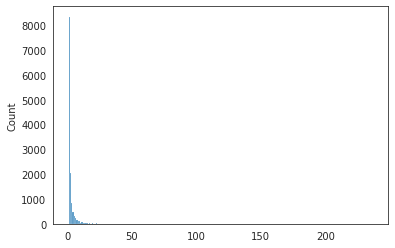

In [236]:
print("Number of all categories: %d" % len(categories_dict.keys()))

categories_sizes = [len(categories_dict[c]) for c in categories_dict.keys()]
sns.histplot(data=categories_sizes, binwidth=1)
plt.plot()

As the figure shows, there is an enormous amount of categories that appeas just once. Let's filter out the categories which appear no more than 5 times.

Number of all categories: 1076


[]

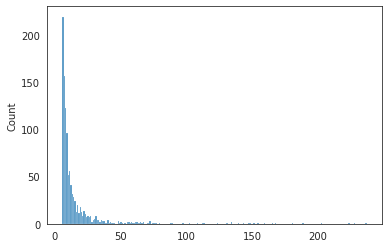

In [237]:
filtered_categories = {c: categories_dict[c] for c in categories_dict.keys() if len(categories_dict[c]) > 5}
print("Number of all categories: %d" % len(filtered_categories.keys()))
categories_sizes = [len(filtered_categories[c]) for c in filtered_categories.keys()]
sns.histplot(data=categories_sizes, binwidth=1)
plt.plot()

Filter categories even more: remove categories which appear no more than 10 times.

Number of all categories: 431


[]

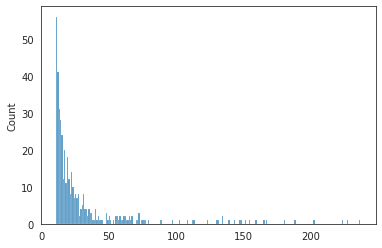

In [238]:
filtered_categories = {c: categories_dict[c] for c in categories_dict.keys() if len(categories_dict[c]) > 10}
print("Number of all categories: %d" % len(filtered_categories.keys()))
categories_sizes = [len(filtered_categories[c]) for c in filtered_categories.keys()]
sns.histplot(data=categories_sizes, binwidth=1)
plt.plot()

We have explored the categories a bit and we think it's reasonable to leave out only the categories which appear at least 10 times. It will also keep the size of the graph reasonable.

### Add categories to the network

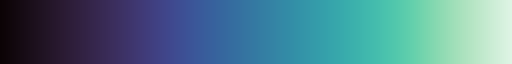

In [239]:
palette = sns.color_palette("mako", as_cmap=True)
palette

In [240]:
G.add_nodes_from([(c, {"category": "category", "color": colors.rgb2hex(palette(i/len(filtered_categories.keys())))}) for i, c in enumerate(filtered_categories.keys())])
for category in filtered_categories.keys():
    for philosopher in filtered_categories[category]:
        G.add_edge(category, philosopher,)

print("Now graph G has %d nodes and %d edges" % (G.number_of_nodes(), G.number_of_edges()))

Now graph G has 2163 nodes and 13141 edges


### Add tags to the network

In [241]:
df_tags = df = pd.read_csv('tagwords.csv')
df_tags.head()

Unnamed: 0                   philosopher  \
0           0           Aaron_Ben-Ze'ev.txt   
1           1  Abd_al-Latif_al-Baghdadi.txt   
2           2        Abdolkarim_Soroush.txt   
3           3           Abdullah_Laroui.txt   
4           4        Abdullah_al-Qasemi.txt   

                                                text  \
0  [("Aaron Ben-Ze'ev", " ('''אהרון בן-זאב'''; bo...   
1  [('ʿAbd al-Laṭīf al-Baghdādī', " ({{lang-ar|عب...   
2  [('Abdolkarim Soroush', " ({{lang|fa|عبدالكريم...   
3  [('Abdallah Laroui', " ({{lang-ar|عبدالله العر...   
4  [('Abdullah al-Qasemi', '  (1907 – 9 January 1...   

                                     preprocess_text  \
0   is an israeli philosopher. he was president o...   
1  , short for  , was a physician, philosopher, h...   
2  , is an iranian islamic thinker, reformer, rum...   
3   is a moroccan philosopher, historian, and nov...   
4    was a saudi arabian 20th-century writer and ...   

                                          text_clean  \
0  israeli philosopher president university haifa...   
1  short physician philosopher historian arabic g...   
2  iranian islamic thinker reformer rumi scholar ...   
3  moroccan philosopher historian novelist work f...   
4  saudi arabian 20thcentury writer intellectual ...   

                                                 tag  
0                        ['university', 'president']  
1                                                 []  
2  ['university', 'professor', 'scholar', 'influe...  
3                       ['philosophical', 'written']  
4                         ['writer', 'world', 'god']

In [242]:
tags_set = set()
for _, row in df.iterrows():
    line = row["tag"].replace("'", "\"")
    tags = json.loads(line)
    for tag in tags:
        tags_set.add(tag)

print("Found %d tags" % len(tags_set))

Found 197 tags


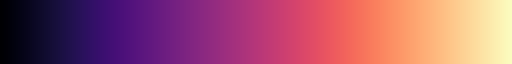

In [243]:
palette = sns.color_palette("magma", as_cmap=True)
palette

In [244]:
G.add_nodes_from([(t, {"category": "tag", "color": colors.rgb2hex(palette(i/len(tags_set)))}) for i, t in enumerate(tags_set)])
for _, row in df.iterrows():
    philosopher = row["philosopher"].replace("_", " ")[:-4]
    line = row["tag"].replace("'", "\"")
    tags = json.loads(line)
    for tag in tags:
        G.add_edge(tag, philosopher)

print("Now graph G has %d nodes and %d edges" % (G.number_of_nodes(), G.number_of_edges()))

Now graph G has 2360 nodes and 22606 edges


### Add edge color attribute

In [245]:
for u, v in G.edges():
    types = nx.get_node_attributes(G, "category")
    colors = nx.get_node_attributes(G, "color")
    if types[u] != "philosopher":
        nx.set_edge_attributes(G, {(u, v): colors[u]}, "color")
    else:
        nx.set_edge_attributes(G, {(u, v): colors[v]}, "color")

In [246]:
nx.set_node_attributes(G, {node: int(G.degree(node)/10) for node in G.nodes()}, "size")

### Remove isolated nodes

In [247]:
print("There are %d isolated nodes in G" % len(list(nx.isolates(G))))

There are 35 isolated nodes in G


In [248]:
G.remove_nodes_from(list(nx.isolates(G)))
print("Now graph G has %d nodes and %d edges" % (G.number_of_nodes(), G.number_of_edges()))

Now graph G has 2325 nodes and 22606 edges


## Visualise the graph

100%|██████████| 2000/2000 [00:22<00:00, 89.36it/s]


Repulsion forces  took  20.66  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.39  seconds
AdjustSpeedAndApplyForces step  took  0.72  seconds


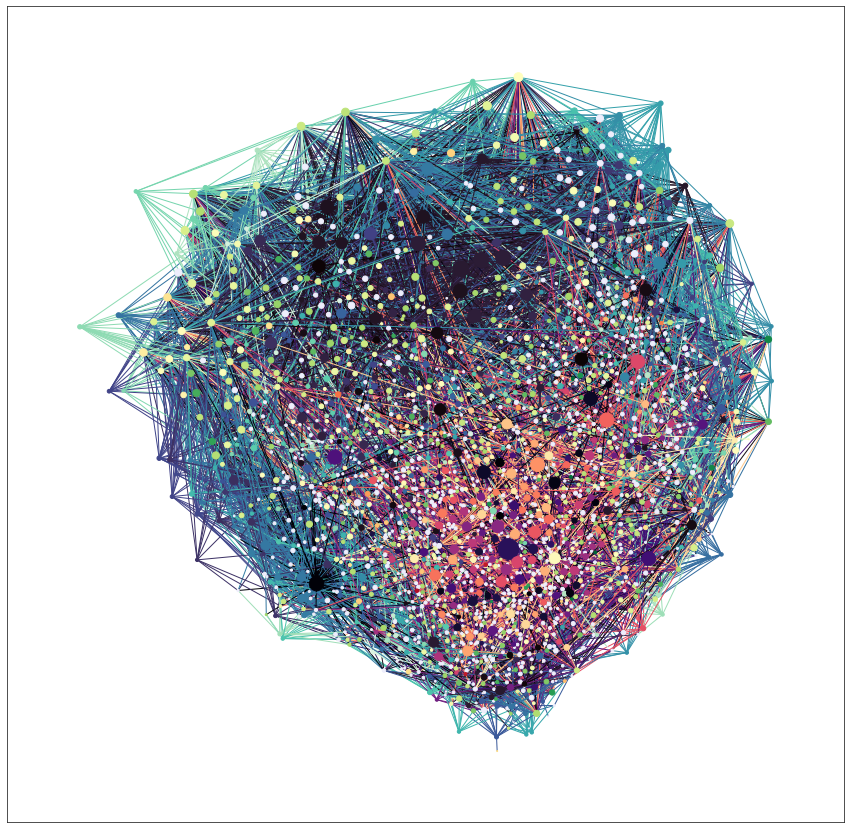

In [249]:
from fa2 import ForceAtlas2

sns.set_style('white')

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,

    # Performance
    jitterTolerance=0.1,  # Tolerance
    barnesHutOptimize=False,
    barnesHutTheta=0.1,

    # Tuning
    scalingRatio=1,
    strongGravityMode=True,
    gravity=3,

    # Log
    verbose=True,
)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

plt.figure(figsize=(15,15))
nodes = G.nodes()
edges = G.edges()
nx.draw_networkx(G,
                  positions,
                  node_size=[G.degree(node) for node in G.nodes()],
                  #node_color=[choose_node_color(node) for node in G.nodes()],
                  node_color=nx.get_node_attributes(G, "color").values(),
                  edge_color=nx.get_edge_attributes(G, "color").values(),
                  with_labels=False)
plt.show()

Beautiful, right? Although in this form maybe not very informative. However, we used SigmaJS library to make this graph more interactive! You can check out the tab `Topics` at one webpage to see the result. 

The code below prepared the data needed for the SigmaJS library.

## Prepare graph for SigmaJS library

### Save positions to graph

In [250]:
position_attrbs = {node: {"x": value[0], "y": value[1]} for node, value in positions.items()}
nx.set_node_attributes(G, position_attrbs)

In [251]:
nx.write_gexf(G, "categories_network.gexf")

## Run some basic statistics on the graph

In [252]:
sns.set_style('darkgrid')

def plot_degree_distribution(degrees, type_of_degree):
    """Plots degree distribution given list of degrees of every node in network
    
    Parameters
    ----------
    degrees : list<int>
        List of number of degrees per every node in the network
    type_of_degree : str
        Degree/In-degree/Out-degree: used in plot's title and axis names
    """
    hist_x, hist_y = np.unique(degrees, return_counts=True)

    plt.figure(figsize=(15,8))
    plt.suptitle("%s distribution" % type_of_degree)
    plt.subplot(2,2,1)

    ax1 = sns.histplot(data=degrees, binwidth=1)
    ax1.set(title="Histogram of the %s distribution" % type_of_degree.lower(), xlabel=type_of_degree, ylabel="Frequency")

    plt.subplot(2,2,2)
    ax2 = sns.scatterplot(x=hist_x, y=hist_y)
    ax2.set(xscale='log', yscale='log', xlabel=type_of_degree, ylabel="Frequency", title="%s distribution (Log-Log)" % type_of_degree)
    ax2.set_ylim(bottom=0.5, top=10e2)
    ax2.set_xlim(left=0.5, right=1000)
    plt.show()

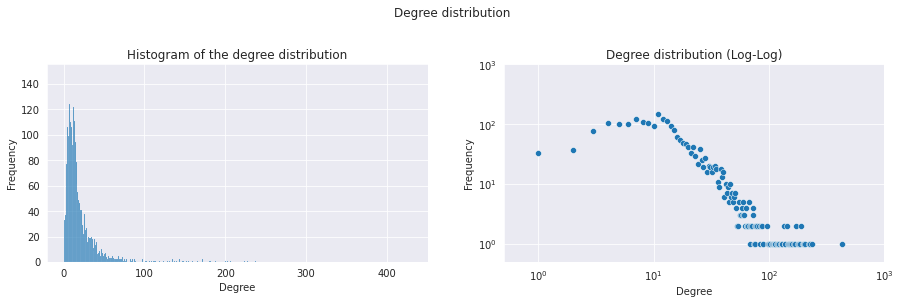

In [253]:
degrees = [G.degree(n) for n in G.nodes()]
plot_degree_distribution(degrees, "Degree")

### Compare degree distribution with random network

Probability of connection $p$:

$ \langle k \rangle = p(N - 1) \Rightarrow p = \frac{\langle k \rangle}{N - 1}$

$ \langle k \rangle = \frac{1}{N}\sum_{i=1}^{N} k_i \Rightarrow p = \frac{\frac{1}{N}\sum_{i=1}^{N} k_i}{N - 1}$

In [254]:
# Number of nodes N
N = G.number_of_nodes()
print("Number of nodes N: %d" % N)

# Probability of connection p
k = sum([G.degree(node) for node in G.nodes()]) / N
p = k / (N - 1)
print("Probability of connection p: %f" % p)

Number of nodes N: 2325
Probability of connection p: 0.008367


In [255]:
# Generate random network with calculated parameters
ER = nx.gnp_random_graph(N, p, directed=False)

# Since we have deleted isolated nodes from network G (Zelda network),
# to make the comparison feasible we will extract the giant component from EX as well
Gcc = sorted(nx.connected_components(ER), key=len, reverse=True)
ER = ER.subgraph(Gcc[0])

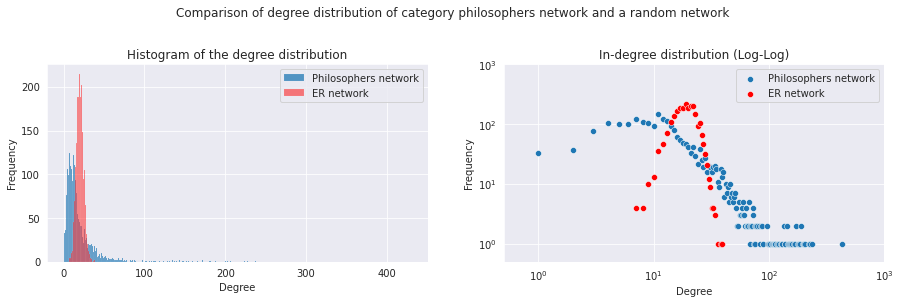

In [256]:
# Plot the degree distribution of both networks
G_degrees = [G.degree(n) for n in G.nodes()]
G_hist_x, G_hist_y = np.unique(G_degrees, return_counts=True)

ER_degrees = [ER.degree(n) for n in ER.nodes()]
ER_hist_x, ER_hist_y = np.unique(ER_degrees, return_counts=True)

plt.figure(figsize=(15,8))
plt.suptitle("Comparison of degree distribution of category philosophers network and a random network")
plt.subplot(2,2,1)

ax1 = sns.histplot(G_degrees, binwidth=1, label="Philosophers network")
ax1 = sns.histplot(ER_degrees, binwidth=1, color="red", label="ER network", alpha=0.5)
ax1.set(title="Histogram of the degree distribution", xlabel="Degree", ylabel="Frequency")
ax1.legend()

plt.subplot(2,2,2)
ax2 = sns.scatterplot(x=G_hist_x, y=G_hist_y, label="Philosophers network")
ax2 = sns.scatterplot(x=ER_hist_x, y=ER_hist_y, label="ER network", color="red")
ax2.set(xscale='log', yscale='log', xlabel='Degree', ylabel="Frequency", title="In-degree distribution (Log-Log)")
ax2.set_ylim(bottom=0.5, top=10e2)
ax2.set_xlim(left=0.5, right=1000)
plt.show()

As the figure shows, the network has distribution very different from the random network. It is closer to the power-law distribution, visible especially at the log-log plot. 

## Communities

Can we divide the graph into some meaningful communities? We use Louvain algorithm to find out.

Since the Louvain algorithm is not deterministic, we have commented out the code generating the new partition and read a file with partition that we generated first instead.

In [257]:
# from community import community_louvain
# louvain = community_louvain.best_partition(G)

# # Save result to file (since the result will be different every time)
# with open("louvain_partition.json", "w") as f:
#     json.dump(louvain, f)

In [258]:
with open("louvain_partition.json", "r") as f:
  louvain = json.load(f)

### Number of communities

In [259]:
print("Number of communities obtained with Louvain algorithm: %d" % len(list(set(louvain.values()))))

Number of communities obtained with Louvain algorithm: 7


### Modularity

We calculate modularity as defined in the equation 9.12 in Chapter 9 of [Network Science book](http://networksciencebook.com/chapter/9#modularity):

$ M = \sum_{c=1}^{n_c} [ \frac{L_c}{L} - (\frac{k_c}{2L})^2 ]$

where $n_c$ is the number of communities the network has been broken into.

In [260]:
def calculate_modularity(H, partition):
  """Calculate modularity of a partition of graph H
  according to the equation above.

  Parameters
  ----------
  H : nx.Graph
    Undirected graph that was partitioned into communities
  partition : dict<str, int>
     A dictionary representing a partition into communities: keys are the nodes of H
     and the values are identifiers of a cluster (community) to which a node has been assigned

  Returns
  ----------
  flot
    The modularity of the partition
  """
  # Number of communities
  n_c = len(list(set(partition.values())))

  # Number of links in total
  L = H.number_of_edges()

  modularity = 0
  for community_id in list(set(partition.values())):
    nodes_in_community = [n for n in H.nodes() if partition[n] == community_id]

    # Create a subgraph only with nodes belonging to the community
    subgraph = H.subgraph(nodes_in_community)

    # Number of links within the community
    L_c = subgraph.number_of_edges()

    # Total degree of the nodes community
    k_c = sum([H.degree(n) for n in nodes_in_community])

    # Calculate modularity of the community and add it to total modularity of H
    modularity += ((L_c / L) - (k_c / (2 * L))*(k_c / (2 * L)))
  return modularity

In [261]:
print("Modularity of the partition of G obtained with Louvain algorithm is %f" % calculate_modularity(G, louvain))

Modularity of the partition of G obtained with Louvain algorithm is 0.370368


0.37 is a pretty satisfactory score - it means that that the clusters are not very abvious to detect, but neither they are totally random.

### Distribution of community sizes

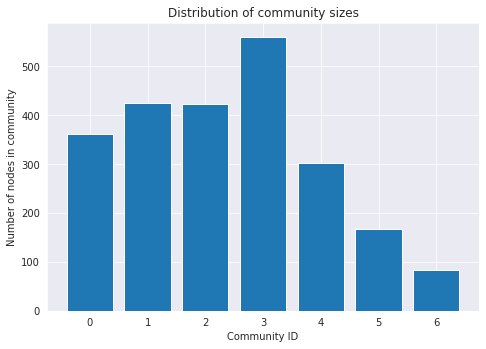

In [262]:
# Prepare the data with distribution of nodes belonging to communities
x = range(0, max(louvain.values()) + 1)
y = [len([1 for n in G.nodes() if louvain[n] == community_id]) for community_id in x]
x = [str(i) for i in x]

# Plot data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x, y)
plt.xlabel("Community ID")
plt.ylabel("Number of nodes in community")
plt.title("Distribution of community sizes")
plt.show()

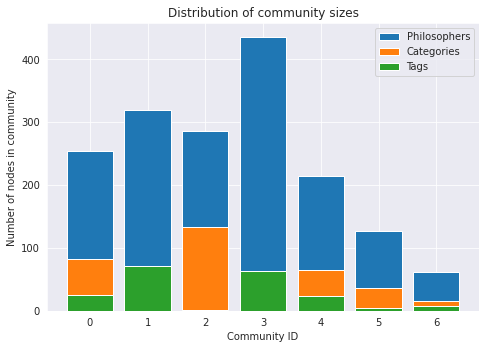

In [263]:
# Prepare the data with distribution of nodes belonging to communities
x = range(0, max(louvain.values()) + 1)
y_philosophers = [len([1 for n in G.nodes() if louvain[n] == community_id and nx.get_node_attributes(G, "category")[n] == "philosopher"]) for community_id in x]
y_categories = [len([1 for n in G.nodes() if louvain[n] == community_id and nx.get_node_attributes(G, "category")[n] == "category"]) for community_id in x]
y_tags = [len([1 for n in G.nodes() if louvain[n] == community_id and nx.get_node_attributes(G, "category")[n] == "tag"]) for community_id in x]
x = [str(i) for i in x]

# Plot data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x, y_philosophers, label='Philosophers')
ax.bar(x, y_categories, label='Categories')
ax.bar(x, y_tags, label='Tags')

ax.legend()
plt.xlabel("Community ID")
plt.ylabel("Number of nodes in community")
plt.title("Distribution of community sizes")
plt.show()

### Add community ID to graph as attribute

In [264]:
nx.set_node_attributes(G, louvain, "community_id")
nx.write_gexf(G, "categories_network.gexf")

## TF-IDF for communities

**Create a document per each community**

We aggregate tokenized contents of pages of characters belonging to the same community into a single list per community and store it in a dictionary.

In [265]:
# Load dictionary with cleaned page per each philosopher
philosopher_tokens_dict = {}
with open('../quotes_analysis/tokens_per_philosopher.json') as f:
  philosopher_tokens_dict = json.load(f)

In [266]:
# Create a document per community
document_per_community = {community_id: [] for community_id in set(louvain.values())}
for philosopher_name, community_id in louvain.items():
    if philosopher_name in philosopher_tokens_dict:
        document_per_community[community_id].extend(philosopher_tokens_dict[philosopher_name])

**Calculate TF**

We calculate Term-Frequency for each token. TF is the raw count of a token in a document divided by the number of all tokens in this document.

$ \text{tf}(t, d) = \frac{f_{t,d}}{\sum_{t'\in d} f_{t',d}} $

In [267]:
TF_per_community = {}
for community in set(louvain.values()):
  tokens = [i for i in document_per_community[community]]
  fdist = nltk.FreqDist(tokens)
  TF_per_community[community] = {}
  number_of_all_tokens = len(tokens)
  for word in list(set(tokens)):
    TF_per_community[community][word] = fdist[word]/number_of_all_tokens

**List 5 top words per community according to TF**

In [268]:
def get_top_5_words(words_dictionary):
  """Get top 5 words sorted by values in the dictionary

  Parameters
  ----------
  words_dictionary : dict<str, float>
    A dictionary with words as keys and their grading as a value

  Returns
  ----------
  list
    List of 5 words with the highest grading
  """
  return sorted([word for word in words_dictionary.keys()], key=lambda x: words_dictionary[x], reverse=True)[:5]

print("Top 5 words per community according to TF:\n - %s" 
      % "\n - ".join(["Community %d: %s" % (community_id, get_top_5_words(TF_per_community[community_id])) for community_id in set(louvain.values())]))

Top 5 words per community according to TF:
 - Community 0: ['one', 'life', 'u', 'must', 'world']
 - Community 1: ['one', 'life', 'god', 'world', 'thing']
 - Community 2: ['one', 'life', 'world', 'thing', 'god']
 - Community 3: ['god', 'one', 'thing', 'u', 'men']
 - Community 4: ['one', 'life', 'may', 'thing', 'would']
 - Community 5: ['one', 'u', 'life', 'men', 'world']
 - Community 6: ['people', 'one', 'society', 'must', 'life']


**Calculate IDF**

We calculate Inverse Document Frequency defined as

$ \text{idf}(t,D) = log \frac{N}{n_t} $

where 
- $N$ is total number of documents in the corpus,
- $n_t$ is number of documents where the term $t$ appears.

In [269]:
# Calculate IDF
IDF = {}
number_of_documents = max(louvain.values())
for community in set(louvain.values()):
  for word in document_per_community[community]:
    if word not in IDF:
      n_t = len([1 for c in set(louvain.values()) if word in document_per_community[c]])
      IDF[word] = np.log(number_of_documents / n_t)

**Calculate TF-IDF**

Given TF and IDF, we can now calculate Term frequency-Inverse document frequency measure:

$\text{tfidf}(t, d, D) = \text{tf}(t, d) * \text{idf}(t, D) $

In [270]:
# Calculate TF-IDF
tf_idf = {}
for community in set(louvain.values()):
  tf_idf[community] = {}
  for word in TF_per_community[community].keys():
    tf_idf[community][word] = TF_per_community[community][word] * IDF[word]

**List 5 top words per community according to TF-IDF**

In [271]:
print("Top 5 words per community according to TF-IDF:\n - %s" 
      % "\n - ".join(["Community %d: %s" % (community_id, get_top_5_words(tf_idf[community_id])) for community_id in set(louvain.values())]))

Top 5 words per community according to TF-IDF:
 - Community 0: ['vietnam', 'alabama', 'segregation', 'birmingham', 'maladjusted']
 - Community 1: ['shakti', 'hindu', 'quantum', 'ul', 'musalmans']
 - Community 2: ['spinozism', 'spinoza', 'ressentiment', 'spinozist', 'pantheism']
 - Community 3: ['bodhisattva', 'buddhahood', 'biblehub', 'slaveholder', 'mahāmati']
 - Community 4: ['kandinsky', 'jubal', 'crowley', 'æquation', 'æquations']
 - Community 5: ['obviousness', 'sisyphus', 'workforce', 'effaces', 'miez']
 - Community 6: ['kuomintang', 'dictatorship', 'centralism', 'soviet', 'speenhamland']


That looks promising! Now we'll generate the following word clouds for every community:
- word cloud of the philosophers in the community
- word cloud of the top tags in the community
- word cloud of top categories in the community
- word cloud of top words according to the TF-DF run agains quotes of the philosophers in the community

## Word clouds

In [272]:
class ColorFromGraphFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color from graph G
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __call__(self, word, **kwargs):
        return nx.get_node_attributes(G, "color")[word]

<Figure size 1080x864 with 0 Axes>

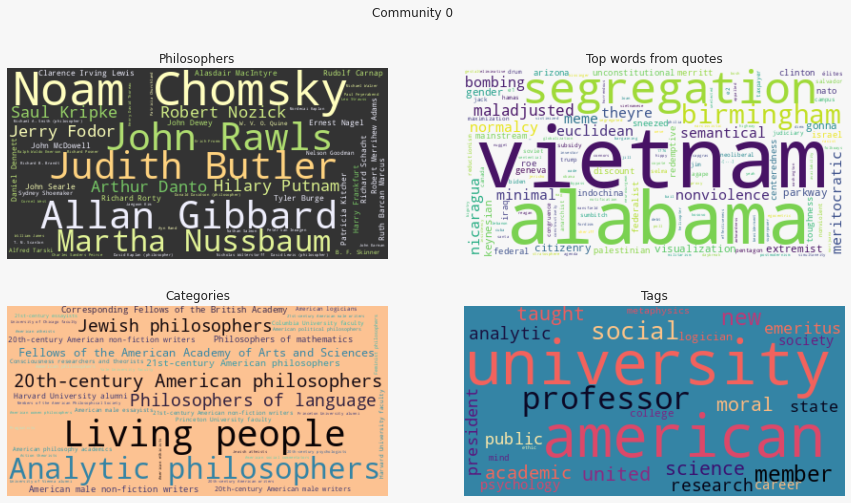

<Figure size 1080x864 with 0 Axes>

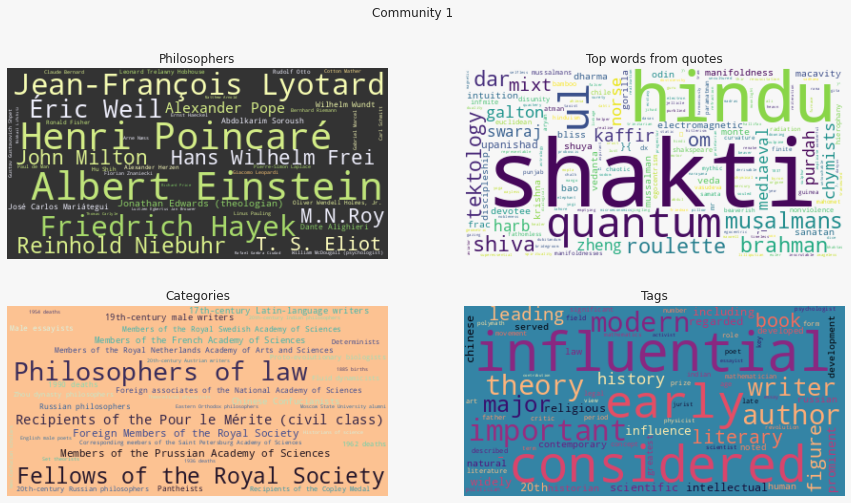

<Figure size 1080x864 with 0 Axes>

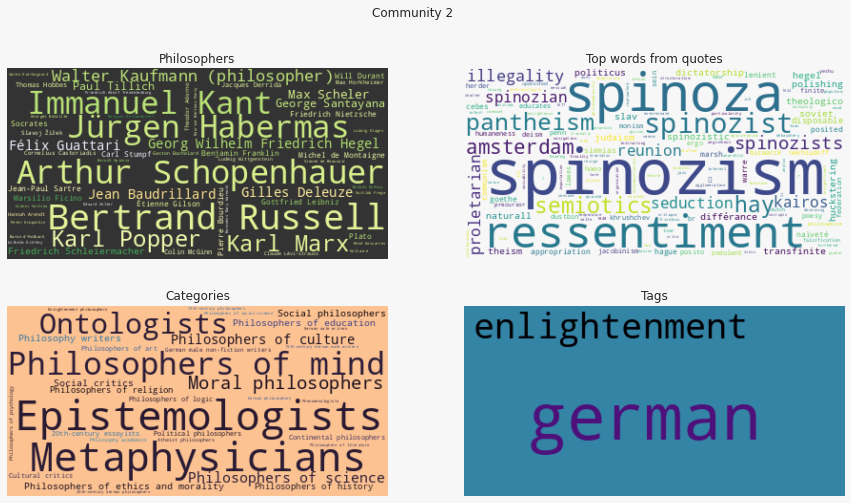

<Figure size 1080x864 with 0 Axes>

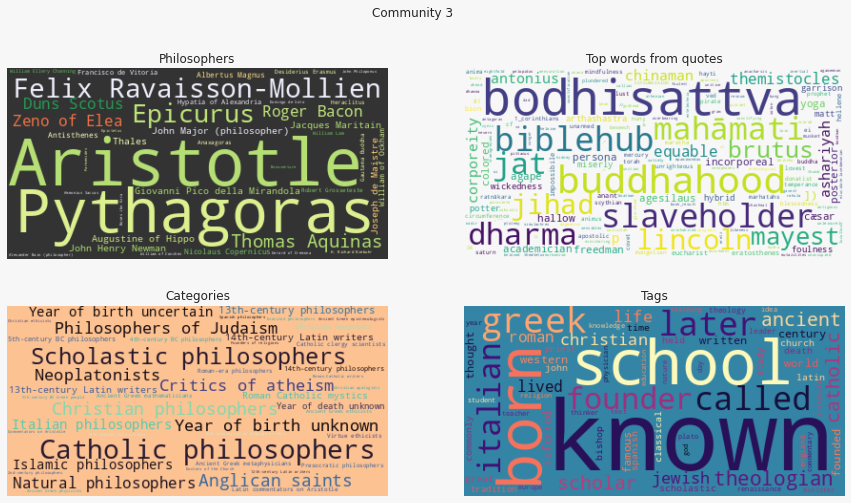

<Figure size 1080x864 with 0 Axes>

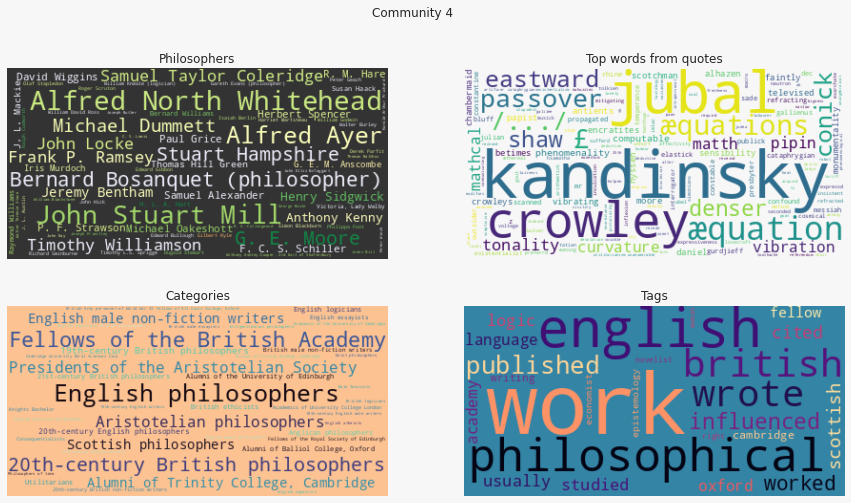

<Figure size 1080x864 with 0 Axes>

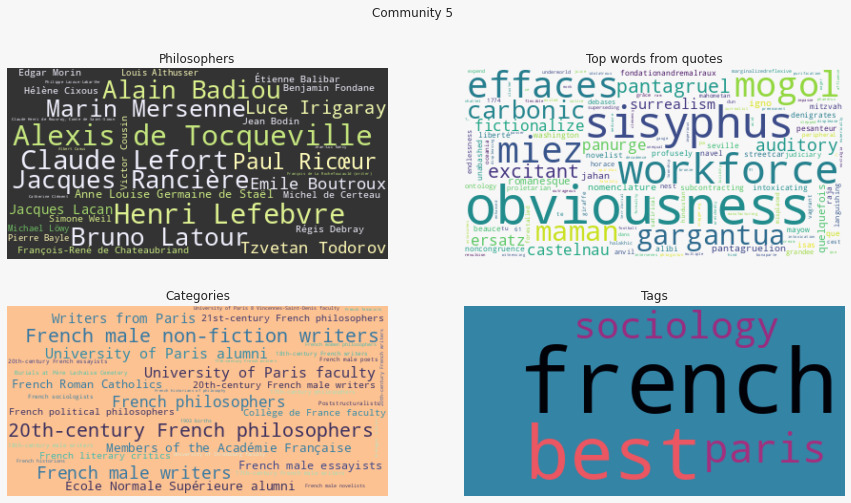

<Figure size 1080x864 with 0 Axes>

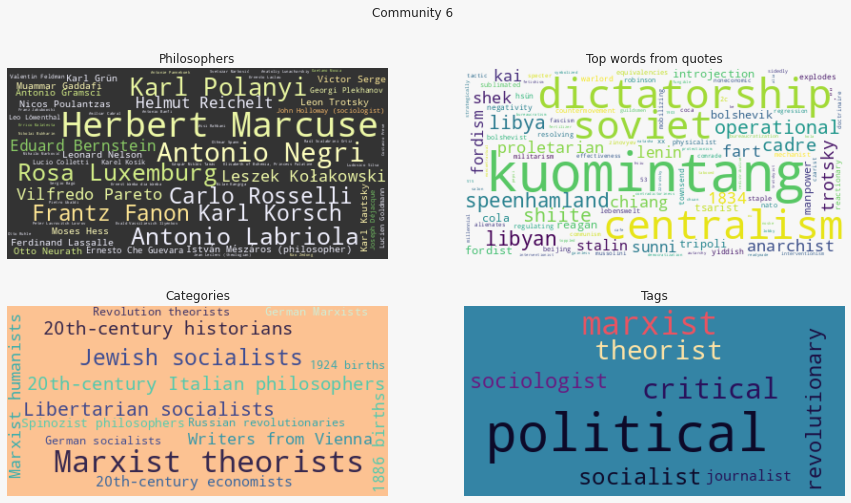

In [273]:
for community_id in range(7):  
  color_func = ColorFromGraphFunc()

  philosophers_in_community = {name: G.degree(name) for name in G.nodes() if nx.get_node_attributes(G, "category")[name] == "philosopher" and louvain[name] == community_id}
  tags_in_community = {name: G.degree(name) for name in G.nodes() if nx.get_node_attributes(G, "category")[name] == "tag" and louvain[name] == community_id}
  categories_in_community = {name: G.degree(name) for name in G.nodes() if nx.get_node_attributes(G, "category")[name] == "category" and louvain[name] == community_id}

  wordcloud_sentiment = WordCloud(background_color="#F7F7F7").generate_from_frequencies(tf_idf[community_id])
  wordcloud_philosophers = WordCloud(background_color="#333333", contour_width=2, color_func=color_func).generate_from_frequencies(philosophers_in_community)
  wordcloud_tags = WordCloud(background_color="#3484A5", contour_width=2, color_func=color_func).generate_from_frequencies(tags_in_community)
  wordcloud_categories = WordCloud(background_color="#FCC292", contour_width=2, color_func=color_func).generate_from_frequencies(categories_in_community)


  plt.figure(figsize=(15,12))
  fig, axs = plt.subplots(2, 2, figsize=(15,8))
  fig.patch.set_facecolor("#F7F7F7")
  axs[0,0].imshow(wordcloud_philosophers, interpolation="bilinear")
  axs[0,0].set_title("Philosophers")
  axs[0,1].imshow(wordcloud_sentiment, interpolation='bilinear')
  axs[0,1].set_title("Top words from quotes")
  axs[1,0].imshow(wordcloud_categories, interpolation='bilinear')
  axs[1,0].set_title("Categories")
  axs[1,1].imshow(wordcloud_tags, interpolation='bilinear')
  axs[1,1].set_title("Tags")
  for ax in fig.get_axes():
    ax.axis("off")
  fig.suptitle("Community %d" % community_id)
  plt.show()

The results exceeded out expecations! One thing that Louvain partition caught excellently is grouping the similar categories like e.g. poets and writers from one country, and assigning tag corresponding to this nationality to the same cluster as well. However, it's not only nationality that the clusters managed to catch, but also age - e.g. community 3 caught very well the Ancient Greek philosophers and community 0 philosophers of today. 

We find the community number 6 very interesting - the algorithm managed to group together the philosophers from the 20th century soviet era, with top words being dictatosrhip and centralism.

# Sentiment across centuries

This is a failed experiment that is not included on the webpage due to poor results.

We run the sentiment analysis once again but this time with documents being quotes from philosophers living in the same century.

## Load tokens

In [276]:
df = pd.read_csv('../../philosophers_with_centuries.csv')
df.head()

Name Birth/death dates                     File name  \
0           Aaron Ben-Ze'ev         born 1949           Aaron_Ben-Ze'ev.txt   
1  Abd al-Latif al-Baghdadi         1162-1231  Abd_al-Latif_al-Baghdadi.txt   
2        Abdolkarim Soroush         born 1945        Abdolkarim_Soroush.txt   
3           Abdullah Laroui         born 1935           Abdullah_Laroui.txt   
4        Abdullah al-Qasemi         1907–1996        Abdullah_al-Qasemi.txt   

   century  
0       20  
1       12  
2       20  
3       20  
4       20

In [277]:
# Load dictionary with cleaned page per each philosopher
philosopher_tokens_dict = {}
with open('tokens_per_philosopher.json') as f:
  philosopher_tokens_dict = json.load(f)

## Create a document per each century

In [278]:
century_tokens = {century: [] for century in df.century.unique()}
for _, row in df.iterrows():
    name = row["Name"]
    century = row["century"]
    if name in philosopher_tokens_dict:
        century_tokens[century].extend(philosopher_tokens_dict[name])

**Calculate TF**

We calculate Term-Frequency for each token. TF is the raw count of a token in a document divided by the number of all tokens in this document.

$ \text{tf}(t, d) = \frac{f_{t,d}}{\sum_{t'\in d} f_{t',d}} $


In [279]:
# Calculate TF
import nltk

TF_per_century = {}
for century in df.century.unique():
  tokens = [i for i in century_tokens[century]]
  fdist = nltk.FreqDist(tokens)
  TF_per_century[century] = {}
  number_of_all_tokens = len(tokens)
  for word in list(set(tokens)):
    TF_per_century[century][word] = fdist[word]/number_of_all_tokens

**List 5 top words per community according to TF**

In [280]:
def get_top_5_words(words_dictionary):
  """Get top 5 words sorted by values in the dictionary

  Parameters
  ----------
  words_dictionary : dict<str, float>
    A dictionary with words as keys and their grading as a value

  Returns
  ----------
  list
    List of 5 words with the highest grading
  """
  return sorted([word for word in words_dictionary.keys()], key=lambda x: words_dictionary[x], reverse=True)[:5]

print("Top 5 words per community according to TF:\n - %s" 
      % "\n - ".join(["Century %d: %s" % (century, get_top_5_words(TF_per_century[century])) for century in sorted(df.century.unique())]))

Top 5 words per community according to TF:
 - Century -19: ['deed', 'bad', 'act', 'according', 'indeed']
 - Century -8: ['god', 'men', 'one', 'thing', 'earth']
 - Century -7: []
 - Century -6: ['one', 'thing', 'may', 'men', 'know']
 - Century -5: ['one', 'thing', 'would', 'life', 'know']
 - Century -4: ['one', 'thing', 'life', 'good', 'know']
 - Century -3: ['one', 'nature', 'human', 'right', 'ritual']
 - Century -2: ['mind', 'yoga', 'becomes', 'reached', 'posture']
 - Century -1: ['one', 'thing', 'men', 'life', 'mind']
 - Century 1: ['said', 'one', ').', 'men', 'thing']
 - Century 2: ['thing', 'thou', 'one', 'translation', 'hay']
 - Century 3: ['one', 'god', 'soul', 'thing', 'body']
 - Century 4: ['god', 'one', 'u', 'christ', 'love']
 - Century 5: ['line', 'thing', 'right', 'one', 'many']
 - Century 6: ['one', 'mind', 'good', 'become', 'would']
 - Century 7: ['god', 'love', 'soul', 'u', 'work']
 - Century 8: ['god', 'saint', 'image', 'relic', 'called']
 - Century 9: ['true', 'ignoranc

**Calculate IDF**

We calculate Inverse Document Frequency defined as

$ \text{idf}(t,D) = log \frac{N}{n_t} $

where 
- $N$ is total number of documents in the corpus,
- $n_t$ is number of documents where the term $t$ appears.

In [281]:
# Calculate IDF
IDF = {}
number_of_documents = len(df.century.unique())
for century in df.century.unique():
  for word in century_tokens[century]:
    if word not in IDF:
      n_t = len([1 for c in df.century.unique() if word in century_tokens[c]])
      IDF[word] = np.log(number_of_documents / n_t)

**Calculate TF-IDF**

Given TF and IDF, we can now calculate Term frequency-Inverse document frequency measure:

$\text{tfidf}(t, d, D) = \text{tf}(t, d) * \text{idf}(t, D) $

In [282]:
# Calculate TF-IDF
tf_idf = {}
for century in df.century.unique():
  tf_idf[century] = {}
  for word in TF_per_century[century].keys():
    tf_idf[century][word] = TF_per_century[century][word] * IDF[word]

**List 5 top words per community according to TF-IDF**

In [283]:
print("Top 5 words per community according to TF-IDF:\n - %s" 
      % "\n - ".join(["Century %d: %s" % (century, get_top_5_words(tf_idf[century])) for century in sorted(df.century.unique())]))

Top 5 words per community according to TF-IDF:
 - Century -19: ['behaves', 'bad', 'reap', 'deed', 'meditate']
 - Century -8: ['zeus', 'priam', 'troy', 'men', 'sleep']
 - Century -7: []
 - Century -6: ['bodhisattva', 'buddhahood', 'mahāmati', 'attains', 'sincerity']
 - Century -5: ['simmias', 'zheng', 'thing', 'bao', 'cebes']
 - Century -4: ['tao', 'thing', 'knowable', 'infinite', 'motion']
 - Century -3: ['rightness', 'ritual', 'indulging', 'aspires', 'tally']
 - Century -2: ['asana', 'yoga', 'posture', 'interruption', 'meditation']
 - Century -1: ['cato', 'fortune', 'mucius', 'thing', 'men']
 - Century 1: [').', 'cæsar', 'said', 'brutus', 'themistocles']
 - Century 2: ['hay', 'translation', 'thou', 'thy', 'thing']
 - Century 3: ['biblehub', 'htm', '])', 'scythian', '1_corinthians']
 - Century 4: ['christ', 'u', 'god', 'love', 'member']
 - Century 5: ['eratosthenes', 'junior', 'theætetus', 'geometry', 'leodamas']
 - Century 6: ['briar', 'severance', 'fallow', 'unfathomably', 'seducing'

## Calculate sentiment per each century

In [284]:
# Read quotes network
G = nx.read_gexf('../quotes_network.gexf')

In [285]:
century_tokens = {century: [] for century in df.century.unique()}

In [286]:
for _, row in df.iterrows():
    century = row["century"]
    name = row["Name"]
    if name in nx.get_node_attributes(G, "sentiment_score"):
        century_tokens[century].append(nx.get_node_attributes(G, "sentiment_score")[name])

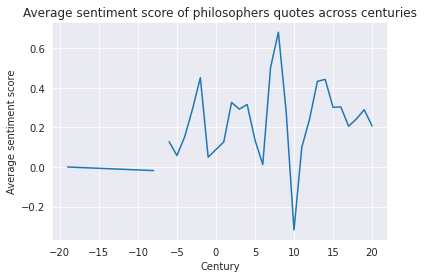

In [288]:
y = [sum(century_tokens[century]) / len(century_tokens[century]) if len(century_tokens[century]) > 0 else None for century in sorted(df.century.unique()) ]
x = sorted(df.century.unique())

plt.plot(x, y)
plt.xlabel("Century")
plt.ylabel("Average sentiment score")
plt.title("Average sentiment score of philosophers quotes across centuries")
plt.show()# Topic modelling with LDA based on philosophers quotes


Unfortunaly, we failed to correlate the plot below with any historic trends or find there anything significnat whatsoever. It may be because of too big granularity - we grouped the quotes based on the century throughout the philosopher who said them lived the most of its life, which may mean that the quote were in fact said in a century before or after.

# Topic modelling with LDA based on philosophers quotes

This is yet another failed experiment that yielded poor results and therefore is not included in the webpage. 

## List of quotes per philosopher



In [289]:
def preprocess_text(content):
    # Make content lowercase
    content = content.lower()

    # Tokenize text
    tokens = nltk.WordPunctTokenizer().tokenize(content)

    # Remove punctuation and stopwords
    stop = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))
    tokens = [i for i in tokens if i not in stop]

    # Lemmatize words
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(i) for i in tokens]

    return tokens

In [292]:
texts = []

for filepath in glob.iglob('philosophers_quotes/*.txt'):
    with open(filepath) as f:
        quotes = json.load(f)
        all_tokens = []
        for quote in quotes:
            all_tokens.extend(preprocess_text(quote))
        texts.append(all_tokens)

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]


## Create inputs to LDA algorithm

In [293]:
dictionary = gensim.corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [294]:
print(dictionary)

Dictionary(22646 unique tokens: ['**', ',"', '...', 'abstain', 'abstract']...)


## LDA model

In [295]:
x = range(3, 60, 1)
y_u_mass = []
y_c_v = []
for num_topics in x:
    coherence_score_u_mass = 0
    coherence_score_c_v = 0
    for i in range(3):
        lda_model = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics)
        corpus_lda = lda_model[corpus]
        coherence_score_u_mass += gensim.models.CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='u_mass').get_coherence()
        coherence_score_c_v += gensim.models.CoherenceModel(model=lda_model, texts=texts, coherence='c_v').get_coherence()
    print("Coherence score for %d topics: %f, %f" % (num_topics, coherence_score_u_mass/10, coherence_score_c_v/10))
    y_u_mass.append(coherence_score_u_mass/10)
    y_c_v.append(coherence_score_c_v/10)



Coherence score for 3 topics: -0.178995, 0.080149
Coherence score for 4 topics: -0.198694, 0.079996
Coherence score for 5 topics: -0.218496, 0.080595
Coherence score for 6 topics: -0.229545, 0.080616
Coherence score for 7 topics: -0.204411, 0.079628
Coherence score for 8 topics: -0.261618, 0.079926
Coherence score for 9 topics: -0.205413, 0.080679
Coherence score for 10 topics: -0.203649, 0.080353
Coherence score for 11 topics: -0.194835, 0.080469
Coherence score for 12 topics: -0.212909, 0.079857
Coherence score for 13 topics: -0.236516, 0.080340
Coherence score for 14 topics: -0.221683, 0.080447
Coherence score for 15 topics: -0.234848, 0.080295
Coherence score for 16 topics: -0.213381, 0.080297
Coherence score for 17 topics: -0.225086, 0.080422
Coherence score for 18 topics: -0.224497, 0.080696
Coherence score for 19 topics: -0.242881, 0.080777
Coherence score for 20 topics: -0.221118, 0.080418
Coherence score for 21 topics: -0.209459, 0.080474
Coherence score for 22 topics: -0.2444

In [296]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_cloud_text(weights, id2token):
    d = {f'{id2token[i]}': int(w * 100000.0) for i, w in enumerate(weights)}
    return d

def create_word_cloud(d):
    wc = WordCloud(background_color='black')
    wc.generate_from_frequencies(d)
    return wc

def plot_word_cloud(w, id2token, size):
    wc_texts = [get_word_cloud_text(w[r], id2token) for r in range(w.shape[0])]
    clouds = [create_word_cloud(text) for text in wc_texts]

    fig, axes = plt.subplots(1, size, figsize=(20, 5))

    for ax, cloud in zip(axes, clouds):
        _ = ax.imshow(cloud, interpolation='bilinear')
        _ = ax.grid(False)
        _ = ax.axis('off')

    plt.tight_layout()
    plt.show()

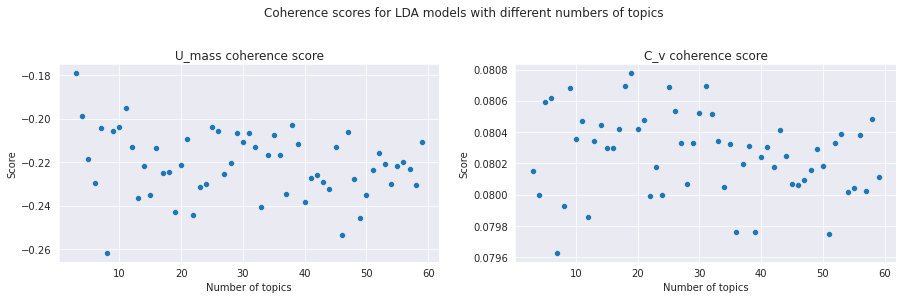

In [297]:
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=(15,8))
plt.suptitle("Coherence scores for LDA models with different numbers of topics")

plt.subplot(2,2,1)
ax1 = sns.scatterplot(x=x, y=y_u_mass)
ax1.set(xlabel="Number of topics", ylabel="Score", title="U_mass coherence score")

plt.subplot(2,2,2)
ax2 = sns.scatterplot(x=x, y=y_c_v)
ax2.set(xlabel="Number of topics", ylabel="Score", title="C_v coherence score")

plt.show()

## LDA model with 6 topics

In [298]:
best_lda_model = None
best_coherence_score_u_mass = -14.
num_topics = 6
for _ in range(10):
    lda_model = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics)
    corpus_lda = lda_model[corpus]
    coherence_score_u_mass = gensim.models.CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='u_mass').get_coherence()
    print(coherence_score_u_mass)
    if coherence_score_u_mass > best_coherence_score_u_mass:
        best_coherence_score_u_mass = coherence_score_u_mass
        best_lda_model = lda_model

print("Chose model with u_mass score %f" % best_coherence_score_u_mass)

-0.7584597520075138
-0.9049960625804431
-0.7654522482644728
-0.4758146899149056
-1.0411042440836444
-0.7397927598730886
-0.5267943754290371
-0.833642967089804
-0.6419420042829178
-0.6463220867803741
Chose model with u_mass score -0.475815


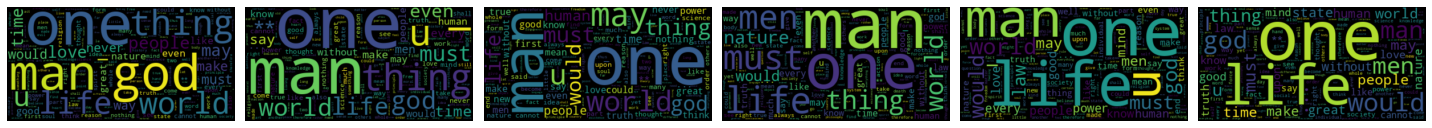

In [299]:
topics = best_lda_model.get_topics()
plot_word_cloud(topics, best_lda_model.id2word.id2token, len(topics))

We have tried the modelling for multiple number of quotes, and unfortunately in all the cases the results were non satisfactory.